<a href="https://colab.research.google.com/github/PkwPanu/Model/blob/main/Fake_News_classification_classicsML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import numpy as np

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_confusion_matrix


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
cd /usr/share/nltk_data/corpora

/usr/share/nltk_data/corpora


In [ ]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [ ]:
cd /kaggle/input/fakenews/

/kaggle/input/fakenews


Data Collection

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
train_data = pd.read_csv("/kaggle/input/fakenews/train.csv")
test_data = pd.read_csv("/kaggle/input/fakenews/test.csv")
submiss_data = pd.read_csv("/kaggle/input/fakenews/sample_submission.csv")


In [ ]:
train_data.head()

In [ ]:
test_data.head()

In [ ]:
submiss_data.head()

Investigate

In [ ]:
train_data.language.value_counts()

In [ ]:
test_data.language.value_counts()

In [ ]:
train_data.isnull().sum()

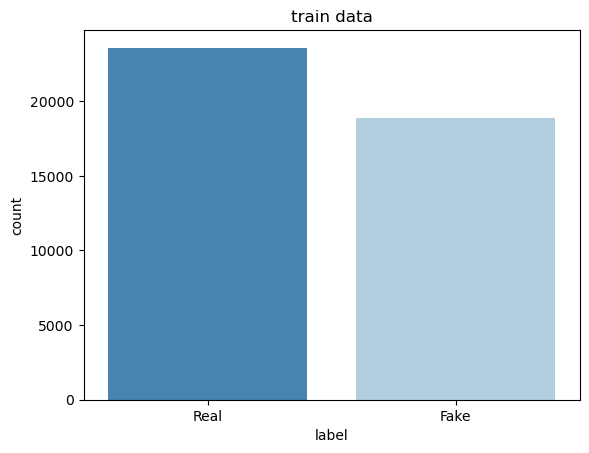

In [ ]:
chart=sns.countplot(x='label',data=train_data,palette='Blues_r')
plt.title("train data");

Preprocessing

In [ ]:
train_data_en=train_data[train_data['language']=='english'].sample(20000)
train_data_th=train_data[train_data['language']=='thai']
print(train_data_en.label.value_counts())
print(train_data_th.label.value_counts())

Real    11122
Fake     8878
Name: label, dtype: int64
Fake    370
Real    363
Name: label, dtype: int64


In [ ]:
#make corpus en
tl=WordNetLemmatizer()
corpus_en=[]
m=len(train_data_en)
for i in np.arange(m):
    print('\r',str(i)+'/'+str(m),end='')
    line =re.sub(r'[^a-zA-Z]',' ',train_data_en.iloc[i]['text'])
    line=line.lower()
    line=line.split()
    line=[tl.lemmatize(word) for word in line if word not in stopwords.words('english')]
    line=" ".join(line)
    corpus_en.append(line)

#save corpus
#import pickle
#with open('corpus.pkl', 'wb') as f:
#     pickle.dump(corpus, f)

 19999/20000

In [ ]:
!pip install pythainlp --upgrade

In [ ]:
#make corpus th
import pythainlp
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import thai_stopwords

corpus_th=[]
m=len(train_data_th)
for i in np.arange(m):
    text = re.sub(r'\n', ' ', train_data_th.iloc[i]['text'])
    text1 = re.sub(r'[^\u0E01-\u0E5B\s]',' ',text)
     # tokenize the sentence
    text1 = word_tokenize(text1, engine="newmm")
    # remove Thai stopwords
    text1 = [t for t in text1 if t not in thai_stopwords()]
    text1=" ".join(text1)
    
    text2 = re.sub(r'[^a-zA-Z]',' ',text)
    text2= text2.lower()
    text2= text2.split()
    text2= [tl.lemmatize(word) for word in text2 if word not in stopwords.words('english')]  
    text2=" ".join(text2)
    
    corpus_th.append(text1 + text2)


In [ ]:
corpus_th[3]

'โครงการ ความคิด ฟรี                                         ฝ่ายตรงข้าม ไปป์ ไลน์ ที่จะ ปกป้อง แหล่งน้ำ                                     ป้องกัน การทำลายล้าง พื้น ที่ฝังศพ สถานที่ ทางวัฒนธรรม ต่อเนื่อง คาด เผชิญหน้า ตำรวจ    ข่าว เกิดขึ้น    ผู้คุ้มครอง น้ำ    ปฏิเสธ คำขอ บังคับใช้ กฎหมาย ออกจาก ที่ดิน จัดวาง ซ้ำ เส้นทาง ท่อ เป็นเจ้าของ พันธมิตร ถ่ายโอน พลังงาน ดัลลัส   สัปดาห์ เคลื่อนไหว พื้นเมือง ดำเนินการ กล้าหาญ ประกาศ โดเมน มีชื่อเสียง เหนือ ดินแดน ดั้งเดิม ตั้งค่าย    แนวหน้า    ค่าย โดยตรง เส้นทาง ท่อ    ฝ่ายตรงข้าม ไปป์ ไลน์ กล่าวว่า เรียกคืน ที่ดิน สนธิสัญญา ฟอ ร์ต ลา รา มี่ ปี   ค   ศ         ชัดเจน         ดินแดน    ค่าย ตั้งอยู่ ข้าม ทางหลวง หมายเลข        เจ้าหน้าที่ รักษา ความปลอดภัย ท่อ อาวุธ ติดอาวุธ สุนัข ยาม สเปรย์ พริกไทย โจมตี ผู้ประท้วง หยุด การสำรวจ สถานที่ ทางวัฒนธรรม พื้น ที่ฝังศพ วันที่     กันยายน   วิกฤต เกิดขึ้น เกิดขึ้น การป้องกัน น้ำ       ตั้งค่าย บก คู่ ค้า ถ่ายโอน พลังงาน เมื่อเดือนที่แล้ว ซื้อ เจ้าของ ฟาร์ม ปศุสัตว์ ความพยายาม ที่จะ หนุน การควบ คุม

In [ ]:
corpus_en[4]

'confident run articulated think could mobilized majority american people rally behind mr obama said mr axelrod podcast axe file referring message inclusion helping american mean organizing mean caring state party mean caring local race state board school board city council state legislative race thinking somehow great set progressive policy present new york time editorial board win day know conversation people around country even people disagreed would say vision direction point towards right one said president obama said think would mr trump said telephone interview monday mr axelrod commentator cnn said sense mr obama frustrated presidency ending party sustained dramatic loss ground communicating dry policy aspect care community bleeding community mr obama said problem mr obama said democratic politician communicating people understand frustrated think winning tendency like sport maybe play safer mr obama said nonsense mr obama said democrat abandoned white american rallied mr trump

In [ ]:
#read corpus
#import pickle
#with open('corpus.pkl', 'rb') as f:
#    corpus = pickle.load(f)

In [ ]:
x_en=corpus_en[:]
y_en=train_data_en['label'].replace(['Real','Fake'],[0,1])
x_train_en, x_test_en, y_train_en, y_test_en = train_test_split(x_en, y_en, test_size=0.60, random_state=1, shuffle =True)

In [ ]:
x_th=corpus_th[:]
y_th=train_data_th['label'].replace(['Real','Fake'],[0,1])
x_train_th, x_test_th, y_train_th, y_test_th = train_test_split(x_th, y_th, test_size=0.60, random_state=1, shuffle =True)

In [ ]:
my_tfidf_en = TfidfVectorizer()
# fit the vectorizer and transform X_train into a tf-idf matrix,
# then use the same vectorizer to transform X_test
x_train_en = my_tfidf_en.fit_transform(x_train_en).toarray()
x_test_en = my_tfidf_en.transform(x_test_en).toarray()


In [ ]:
my_tfidf_th = TfidfVectorizer()

x_train_th = my_tfidf_th.fit_transform(x_train_th).toarray()
x_test_th = my_tfidf_th.transform(x_test_th).toarray()

Model

In [ ]:
train_scores = []
test_scores = []

def algorithm(model,x_train,y_train,x_test,y_test):
    # Training model
    model.fit(x_train,y_train)
            
    # score of train set
    train_model_score = model.score(x_train,y_train)
    train_scores.append(round(train_model_score,2))
    y_pred_train=model.predict(x_train)
    
    # score of test set
    test_model_score = model.score(x_test,y_test)
    test_scores.append(round(test_model_score,2))
    y_pred_test=model.predict(x_test)

     # Printing results
    print("Train score :",round(train_model_score,2))
    print("Test score :",round(test_model_score,2))
    
    #df_model = pd.DataFrame(classification_report(y_pred_test,y_test, digits=2,output_dict=True)).T
    #df_model.style.background_gradient(cmap='viridis',subset=pd.IndexSlice['0':'9', :'f1-score'])
    #display(df_model)
    
    print("Confusion Matrix \n")
    conf_mat = confusion_matrix(y_test, y_pred_test)
    plot_confusion_matrix(conf_mat,
                      show_normed=True, colorbar=True
                      )
    plt.show()
    return model

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

Train score : 1.0
Test score : 0.85
Confusion Matrix 



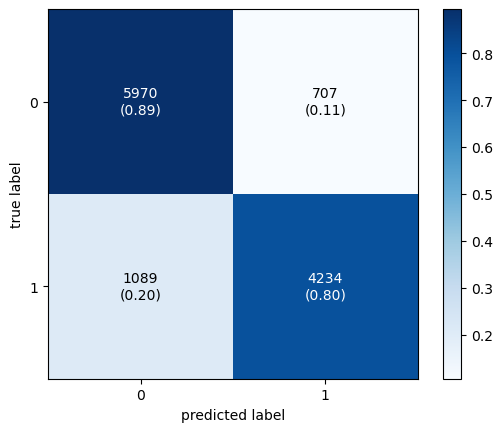

In [ ]:
rf=RandomForestClassifier()
model_RandomForest_en=algorithm(rf,x_train_en,y_train_en,x_test_en,y_test_en)

Train score : 1.0
Test score : 0.47
Confusion Matrix 



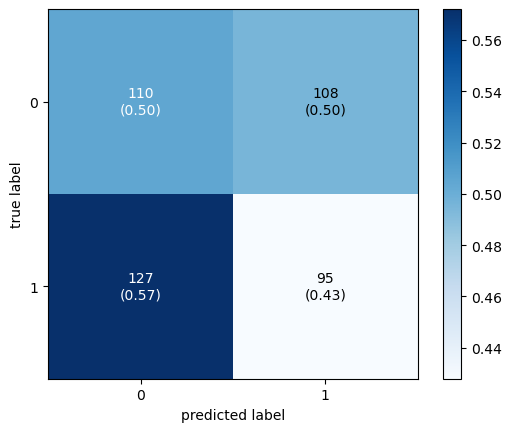

In [ ]:
rf=RandomForestClassifier()
model_rf_th=algorithm(rf,x_train_th,y_train_th,x_test_th,y_test_th)

Train score : 0.9
Test score : 0.84
Confusion Matrix 



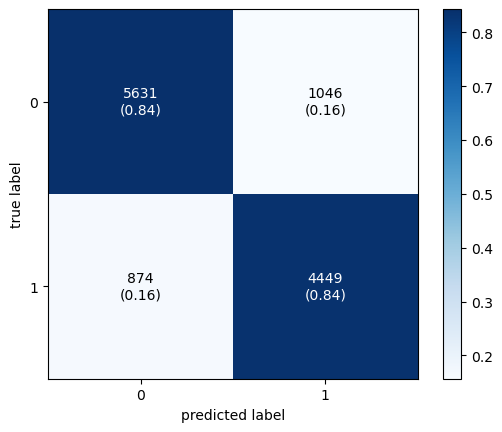

In [ ]:
bnv=BernoulliNB()
model_bnv_en=algorithm(bnv,x_train_en,y_train_en,x_test_en,y_test_en)

Train score : 0.99
Test score : 0.5
Confusion Matrix 



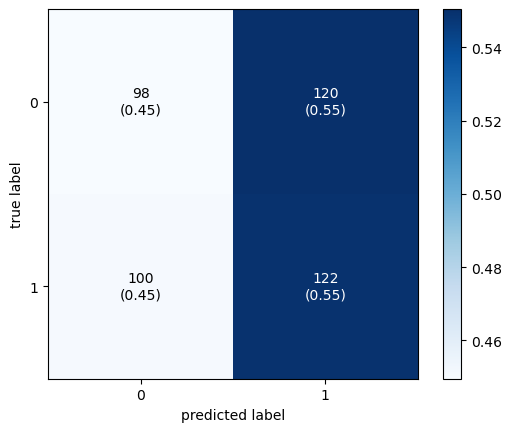

In [ ]:
bnv=BernoulliNB()
model_bnv_th=algorithm(bnv,x_train_th,y_train_th,x_test_th,y_test_th)

Train score : 1.0
Test score : 0.89
Confusion Matrix 



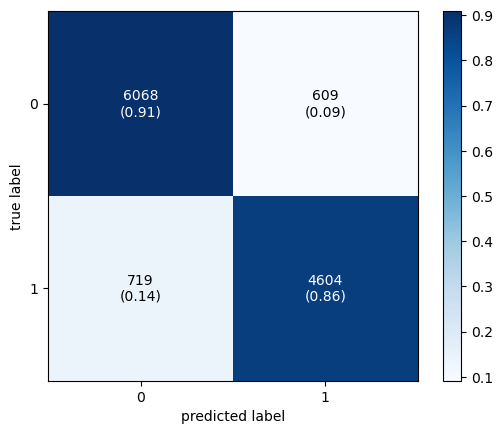

In [ ]:
mlp=MLPClassifier()
model_mlp_en=algorithm(mlp,x_train_en,y_train_en,x_test_en,y_test_en)

Train score : 1.0
Test score : 0.5
Confusion Matrix 



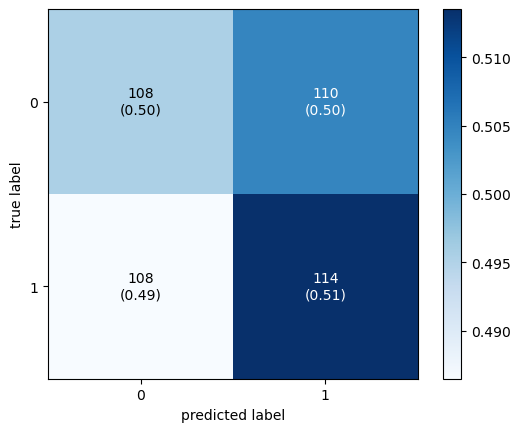

In [ ]:
mlp=MLPClassifier()
model_mlp_th=algorithm(mlp,x_train_th,y_train_th,x_test_th,y_test_th)

Train score : 1.0
Test score : 0.89
Confusion Matrix 



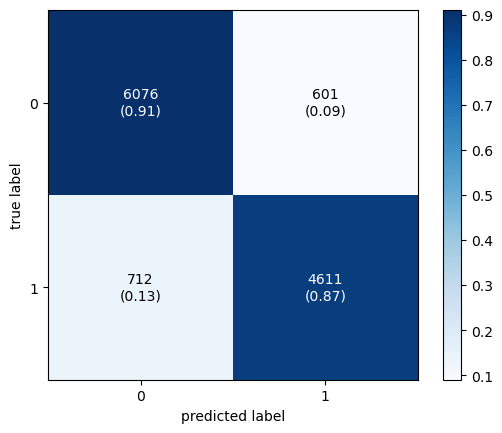

In [ ]:
gnv=GaussianNB()
model_gnv_en=algorithm(mlp,x_train_en,y_train_en,x_test_en,y_test_en)

Train score : 1.0
Test score : 0.49
Confusion Matrix 



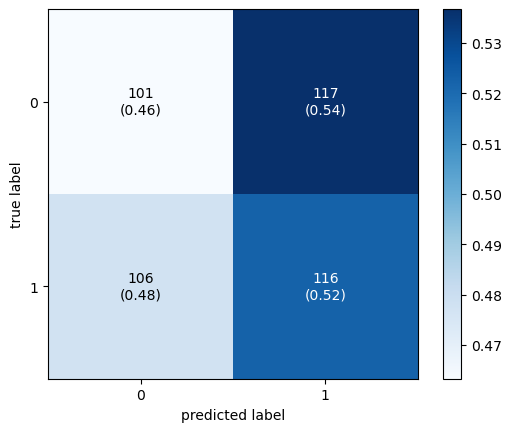

In [ ]:
gnv=GaussianNB()
model_gnv_th=algorithm(mlp,x_train_th,y_train_th,x_test_th,y_test_th)

In [ ]:
for i in test_data.id:
    test_data.text[]

y1=model_gnv_en.predict()
y2=model_mlp_en.predict()
y3=model_RandomForest_en.predict()

In [ ]:
import warnings
# turn off the SettingWithCopyWarning
warnings.filterwarnings('ignore', category=pd.core.common.SettingWithCopyWarning)

tl=WordNetLemmatizer()
m=len(test_data.index)
for n,i in enumerate(test_data.index):
    if (test_data.loc[i]['language'] == 'english'):
        print('\r',str(n)+'/'+str(m),end='')
        line =re.sub(r'[^a-zA-Z]',' ',np.array(test_data.text[test_data.index == i]).reshape(-1)[0])
        line=line.lower()
        line=line.split()
        line=[tl.lemmatize(word) for word in line if word not in stopwords.words('english')]
        line=" ".join(line)
        line=my_tfidf_en.transform([line]).toarray()
        y1=model_gnv_en.predict(line)[0]
        y2=model_mlp_en.predict(line)[0]
        y3=model_RandomForest_en.predict(line)[0]
        test_data.y1[test_data.index == i]=y1
        test_data.y2[test_data.index == i]=y2
        test_data.y3[test_data.index == i]=y3
        test_data.Mode[test_data.index == i]=statistics.mode([y1,y2,y3])

 E8UBWYESTvz5JXDykmTtXX/20909

In [ ]:
test_data['Mode']=test_data['Mode'].replace([0,1],['Real','Fake'])
Predicted=pd.DataFrame(test_data.Mode,test_data.index)
Predicted = Predicted.rename(columns={'Mode': 'label'})

In [ ]:
Predicted.value_counts()

label
Real     12021
Fake      8888
dtype: int64

In [ ]:
cd /kaggle/working/

/kaggle/working


In [ ]:
Predicted.to_csv('Predicted.csv')


Conclusion

The accuracy of the test dataset for English text is around 0.9. However, for Thai text, there are too few samples to capture the patterns using the same preprocessing techniques and models as for English text.

